In [2]:
import torch
import mamba_ssm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm.notebook import trange

/gpfs/users/goon/.pyenv/versions/3.9.20/envs/mamba/lib/python3.9/site-packages/mamba_ssm/ops/selective_scan_interface.py:164: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, xz, conv1d_weight, conv1d_bias, x_proj_weight, delta_proj_weight,
/gpfs/users/goon/.pyenv/versions/3.9.20/envs/mamba/lib/python3.9/site-packages/mamba_ssm/ops/selective_scan_interface.py:240: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, dout):
/gpfs/users/goon/.pyenv/versions/3.9.20/envs/mamba/lib/python3.9/site-packages/mamba_ssm/ops/triton/layer_norm.py:986: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(
/gpfs/users/goon/.pyenv/versions/3.9.20/envs/mamba/lib/python3.9/site-packages/mamba_

In [3]:
in_features_min=512
in_features_max=4096
seq_len=4096
bsz=8
device="cuda"

In [4]:
from mamba_ssm.modules.mlp import GatedMLP

mlp_amp = False
mlp_results = []
for in_features in trange(in_features_min, in_features_max+1, 128):
    mlp = GatedMLP(in_features, device=device)
    inputs = torch.randn(bsz, seq_len, in_features, device=device)
    with torch.no_grad():
        with torch.autocast(device_type="cuda", dtype=torch.bfloat16, enabled=mlp_amp):
            outputs = mlp(inputs)
    mlp_results_dict = {"in_features": in_features,
                    "l2_mean": outputs.pow(2).mean().item(),
                    "l1_mean": outputs.abs().mean().item(),
                    "l2_sum": outputs.pow(2).sum().item(),
                    "l1_sum": outputs.abs().sum().item(),
                    "std": outputs.std().item(),
                    "var": outputs.var().item(),
                    "mean": outputs.mean().item(),
                   }
    mlp_results.append(mlp_results_dict)
    
mlp_df = pd.DataFrame(mlp_results)
mlp_df

  0%|          | 0/29 [00:00<?, ?it/s]

,in_features,l2_mean,l1_mean,l2_sum,l1_sum,std,var,mean
0,512,0.011150,0.083989,1.870731e+05,1.409095e+06,0.105596,0.011150,0.000125
1,640,0.011139,0.083996,2.335919e+05,1.761534e+06,0.105539,0.011139,-0.000168
2,768,0.011123,0.083972,2.799247e+05,2.113218e+06,0.105466,0.011123,0.000331
3,896,0.011124,0.084002,3.265944e+05,2.466309e+06,0.105469,0.011124,0.000036
4,1024,0.011079,0.083855,3.717393e+05,2.813704e+06,0.105255,0.011079,-0.000089
5,1152,0.011121,0.084020,4.197862e+05,3.171641e+06,0.105454,0.011121,0.000042
6,1280,0.011113,0.084005,4.661209e+05,3.523443e+06,0.105419,0.011113,0.000128
7,1408,0.011094,0.083942,5.118560e+05,3.872863e+06,0.105329,0.011094,-0.000040
8,1536,0.011093,0.083949,5.583232e+05,4.225271e+06,0.105323,0.011093,-0.000038
9,1664,0.011104,0.083996,6.054462e+05,4.579984e+06,0.105375,0.011104,0.000086


Text(0.5, 0.98, 'MLP scaling')

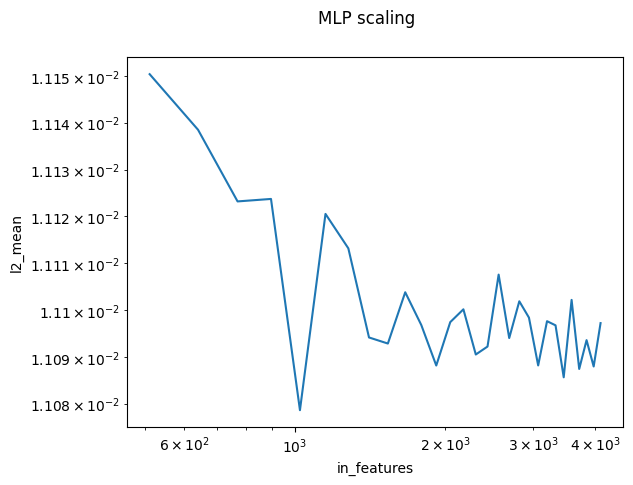

In [5]:
mlp_plot = sns.lineplot(data=mlp_df, x="in_features", y="l2_mean")
mlp_plot.set(xscale="log")
mlp_plot.set(yscale="log")
plt.suptitle("MLP scaling")

In [6]:
from mamba_ssm.modules.mha import MHA

attn_results = []
attn_amp = False
for in_features in trange(in_features_min, in_features_max+1, head_dim):
    attn_cfg = {
    "causal": True,
    "head_dim": head_dim,
    "num_heads": in_features // head_dim,
    "out_proj_bias": False,
    "qkv_proj_bias": False,
    "rotary_emb_dim": head_dim // 2,  # Apparently correct for mamba-ssm
}

    mha = MHA(in_features, **attn_cfg, device=device)
    inputs = torch.randn(bsz, seq_len, in_features, device=device)
    with torch.no_grad():
        with torch.autocast(device_type="cuda", dtype=torch.bfloat16, enabled=attn_amp):
            outputs = mha(inputs)
    attn_results_dict = {"in_features": in_features,
                    "l2_mean": outputs.pow(2).mean().item(),
                    "l1_mean": outputs.abs().mean().item(),
                    "l2_sum": outputs.pow(2).sum().item(),
                    "l1_sum": outputs.abs().sum().item(),
                    "std": outputs.std().item(),
                    "var": outputs.var().item(),
                    "mean": outputs.mean().item(),
                   }
    attn_results.append(attn_results_dict)

attn_df = pd.DataFrame(attn_results)
attn_df


NameError: name 'head_dim' is not defined

In [ ]:
attn_plot = sns.lineplot(data=attn_df, x="in_features", y="l2_mean")
attn_plot.set(xscale="log")
attn_plot.set(yscale="log")

plt.suptitle("MHA scaling")

In [ ]:
import torch.nn as nn
from typing import Any, Optional

class InputStatsHook:
    def __init__(
        self,
        module: nn.Module,
        name: str,
        results_list: list[dict],
        width: int,
        other_data: Optional[dict] = None,
    ) -> None:
        self.module = module
        self.name = name
        self.width = width
        self.results_list = results_list
        self._hook = module.register_forward_pre_hook(self)
        self._step = 0
        self.other_data = other_data or {}

    def __call__(self, module: nn.Module, args: Any) -> None:
        inputs = args[0]
        results = {"name": self.name, "width": self.width, "step": self._step}
        results = {**results, **self.other_data}
        with torch.no_grad():
            results["mean"] = inputs.mean().item()
            results["l1_mean"] = inputs.abs().mean().item()
            results["l2_mean"] = inputs.pow(2).mean().item()
            results["std"] = inputs.std().item()
            results["var"] = inputs.var().item()
        self.results_list.append(results)
        self._step += 1



    def remove(self) -> None:
        self._hook.remove()


In [ ]:
from mamba_ssm.models.config_mamba import MambaConfig
from mamba_ssm.models.mixer_seq_simple import MambaLMHeadModel
from fms_fsdp.mup.mup_mamba import apply_mup_init


model_results = []
lm_head_input_results = []
model_amp = True
mup = True
n_layer=4
vocab_size=128256
head_dim=128
for in_features in trange(in_features_min, in_features_max+1, 4*head_dim):
    attn_cfg = {
    "causal": True,
    "head_dim": head_dim,
    "num_heads": in_features // head_dim,
    "out_proj_bias": False,
    "qkv_proj_bias": False,
    "rotary_emb_dim": head_dim // 2,  # Apparently correct for mamba-ssm
}
    if mup:
        attn_cfg["softmax_scale"] = head_dim
    
    config = MambaConfig(
    d_model=in_features,
    d_intermediate=4 * in_features,
    n_layer=n_layer,
    attn_layer_idx=list(range(n_layer)),  # Transformer-only blocks
    vocab_size=vocab_size,
    attn_cfg=attn_cfg,
    tie_embeddings=False,
)
    model = MambaLMHeadModel(config=config, device=device)

    hook = InputStatsHook(model.lm_head, "lm_head", lm_head_input_results, width=in_features)
    if mup:
        apply_mup_init(model)
    inputs = torch.randint(vocab_size, size=(bsz, seq_len), device=device)
    with torch.no_grad():
        with torch.autocast(device_type="cuda", dtype=torch.bfloat16, enabled=model_amp):
            outputs = model(inputs).logits
        print(f"{outputs.shape=}, {in_features=}")
    model_results_dict = {"in_features": in_features,
                    "l2_mean": outputs.pow(2).mean().item(),
                    "l1_mean": outputs.abs().mean().item(),
                    "l2_sum": outputs.pow(2).sum().item(),
                    "l1_sum": outputs.abs().sum().item(),
                    "std": outputs.std().item(),
                    "var": outputs.var().item(),
                    "mean": outputs.mean().item(),
                   }
    model_results.append(model_results_dict)
model_df = pd.DataFrame(model_results)
model_df


In [ ]:
model_plot = sns.lineplot(data=model_df, x="in_features", y="l2_mean")
model_plot.set(xscale="log")
model_plot.set(yscale="log")

plt.suptitle("Model scaling")


In [ ]:
lm_head_df = pd.DataFrame(lm_head_input_results)
lm_head_df


In [ ]:
lm_head_plot = sns.lineplot(data=lm_head_df, x="width", y="l2_mean")
lm_head_plot.set(xscale="log")
lm_head_plot.set(yscale="log")

plt.suptitle("LM Head scaling")

In [ ]:
lm_head_df